In [1]:
import psycopg2
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres",
    password="postgres"
)

cur = conn.cursor()

cur.execute("SELECT version();")
print(cur.fetchone())

('PostgreSQL 15.2, compiled by Visual C++ build 1914, 64-bit',)


In [5]:
# Connect to db
conn = psycopg2.connect(host='localhost', dbname='mimic', user='postgres', password='postgres', options='-c search_path=mimiciii')
#conn = psycopg2.connect(dbname='mimic', user='postgres')
cur = conn.cursor() 

# Read in table with patients & admissions (inner join on subject_id) and icu_stays (inner joinon subject_id and hadm_id)
icustay_details = pd.read_sql_query("SELECT * FROM mimiciii.flicu_icustay_detail;", conn)

# Read in vital and lab signs
pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
pivoted_lab = pd.read_sql_query("SELECT * FROM mimiciii.ckd_pivoted_lab;", conn)

# Read in lab measurements
# Use flicu_pivoted_lab (as it only takes the lab tests during ICU stay)
#query = "SELECT * FROM mimiciii.flicu_pivoted_lab;"
# Alternative:  Use the lab values recorded previous to the ICU stay (although during same hospital admission!), 
# then sample them  (8h intervalls) and then forward fill plus cap at either icu admission time of first vital sign recorded
#query = "SELECT * FROM mimiciii.pivoted_lab;"
#pivoted_lab = pd.read_sql_query(query, conn)

# Close the cursor and connection to so the server can allocate bandwidth to other requests
cur.close()
conn.close()

C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
icustay_details.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'admission_age', 'ethnicity',
       'ethnicity_grouped', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay_current_hosp', 'first_icu_stay_patient',
       'first_careunit', 'deathtime_icu', 'label_death_icu', 'label_cor_art',
       'diabetes_mellitus', 'ckd', 'anemia_flag'],
      dtype='object')

In [6]:
icustay_details.head()

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity,...,icustay_seq,first_icu_stay_current_hosp,first_icu_stay_patient,first_careunit,deathtime_icu,label_death_icu,label_cor_art,diabetes_mellitus,ckd,anemia_flag
0,58817,128681,228400,F,NaT,2118-05-02 06:24:00,2118-05-25 11:30:00,23.212500,41.321280,WHITE,...,1,True,True,SICU,NaT,0,0,0,0,0
1,5216,130232,262702,M,NaT,2114-02-21 21:03:00,2114-03-07 14:55:00,13.744444,0.014338,WHITE,...,1,True,True,NICU,NaT,0,0,0,0,0
2,31198,131827,202867,M,NaT,2201-04-07 04:30:00,2201-04-14 13:55:00,7.392361,36.117075,WHITE,...,1,True,False,SICU,NaT,0,0,1,0,0
3,788,139716,223805,F,NaT,2194-01-13 20:48:00,2194-01-18 14:30:00,4.737500,71.491964,WHITE,...,1,True,True,MICU,NaT,0,0,0,0,0
4,21185,140466,226095,F,NaT,2141-08-17 02:52:00,2141-08-28 21:30:00,11.776389,44.858261,WHITE,...,1,True,False,CCU,NaT,0,0,0,0,0


In [7]:
icustay_details['ethnicity_grouped'].value_counts()

white               42833
unknown              7859
black                5955
hispanic             2191
asian                2024
portuguese             70
alaska_native          57
middle_eastern         44
pacific_islander       18
Name: ethnicity_grouped, dtype: int64

In [8]:
icustay_details['hadm_id'].value_counts()

186706    7
163281    7
175448    6
123178    6
109520    6
         ..
134341    1
134342    1
134343    1
134344    1
199941    1
Name: hadm_id, Length: 57328, dtype: int64

In [9]:
icustay_details[icustay_details['subject_id']==85]

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity,...,icustay_seq,first_icu_stay_current_hosp,first_icu_stay_patient,first_careunit,deathtime_icu,label_death_icu,label_cor_art,diabetes_mellitus,ckd,anemia_flag
7433,85,112077,291697,M,2167-09-12,2167-07-25 18:49:00,2167-07-30 15:24:00,4.857639,76.849829,WHITE,...,1,True,False,MICU,NaT,0,0,0,1,0
10225,85,116630,209562,M,2167-09-12,2162-03-02 14:04:00,2162-03-10 13:15:00,7.965972,71.455485,WHITE,...,1,True,True,CSRU,NaT,0,1,0,0,0


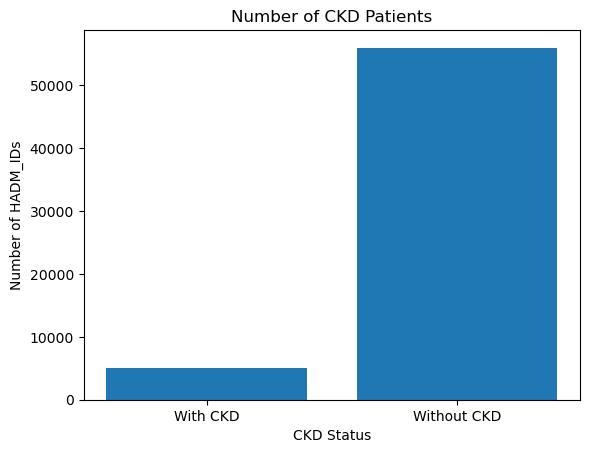

In [12]:
num_with_ckd = icustay_details['ckd'].sum()
num_without_ckd = len(icustay_details) - num_with_ckd

plt.title('Number of CKD Patients')
plt.bar(['With CKD', 'Without CKD'], [num_with_ckd, num_without_ckd])
plt.xlabel('CKD Status')
plt.ylabel('Number of HADM_IDs')
plt.show()

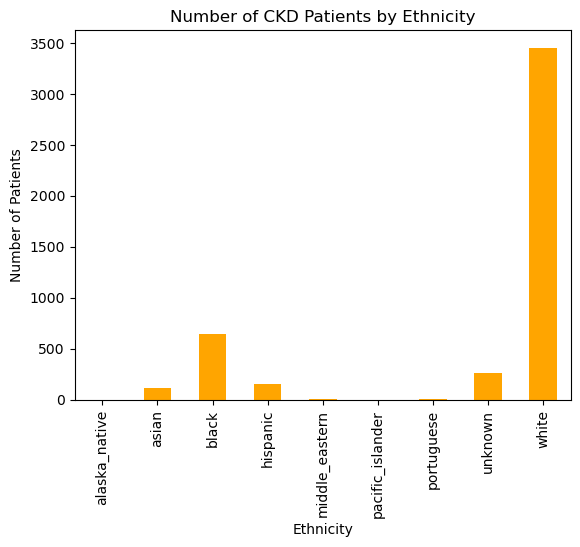

In [14]:
ckd_ethnicity = icustay_details[icustay_details['ckd']==True].groupby('ethnicity_grouped')['hadm_id'].nunique()
ckd_ethnicity.plot(kind='bar', title='Number of CKD Patients by Ethnicity',color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Patients')
plt.show()

In [15]:
ckd_patients = icustay_details.loc[icustay_details['ckd'] == True]
ckd_counts = ckd_patients['ethnicity_grouped'].value_counts()
print(ckd_counts)

white               3761
black                701
unknown              290
hispanic             161
asian                120
portuguese            11
middle_eastern        11
alaska_native          2
pacific_islander       1
Name: ethnicity_grouped, dtype: int64


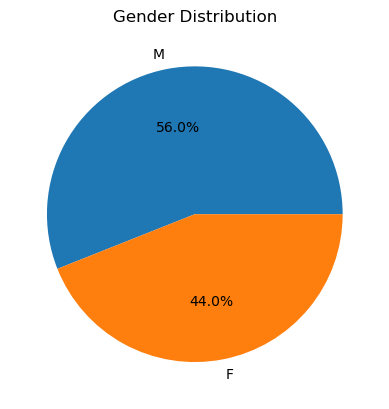

In [16]:
gender_counts = icustay_details['gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

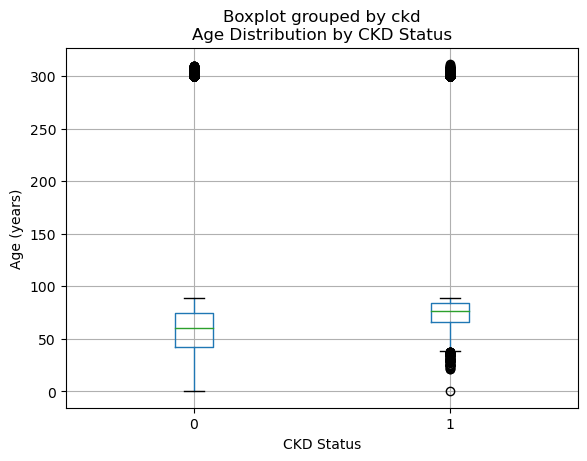

In [17]:
icustay_details.boxplot(column='admission_age', by='ckd')
plt.title('Age Distribution by CKD Status')
plt.xlabel('CKD Status')
plt.ylabel('Age (years)')
plt.show()

PIVOTED VITALS AND LAB

In [18]:
pivoted_vital.head(5)

,icustay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose,rbc,specificgravity,pedaledema,appetite_median,ckd
0,200001,2181-11-25 19:06:00,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,200001,2181-11-25 19:07:00,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,200011,2188-08-06 16:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,0.0
3,200028,2133-10-30 16:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,335.0,NaN,NaN,NaN,NaN,0.0
4,200001,2181-11-25 19:08:00,NaN,113.0,65.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [61]:
pivoted_vital.describe()

,icustay_id,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose,rbc,specificgravity,pedaledema,appetite_median,ckd
count,9.207039e+06,7.931947e+06,5.778812e+06,5.777027e+06,5.794034e+06,6.273229e+06,1.733606e+06,6.080840e+06,1.264135e+06,7578.000000,14424.000000,1.0,31612.000000,9.206869e+06
mean,2.506189e+05,1.014094e+02,1.215081e+02,6.027904e+01,7.915051e+01,2.020732e+01,3.700478e+01,9.708047e+01,1.424546e+02,4.063564,1.014318,2.0,2.418607,8.283250e-02
std,2.887068e+04,3.279276e+01,2.368822e+01,1.455537e+01,1.673107e+01,6.043442e+00,8.432987e-01,3.495480e+00,1.258962e+03,0.638198,0.010064,NaN,0.761893,2.756289e-01
min,2.000010e+05,1.460000e-01,6.000000e-02,3.200000e-01,4.300000e-01,1.700000e-01,1.500000e+01,5.000000e-01,1.060000e-01,0.000000,0.000000,2.0,1.000000,0.000000e+00
25%,2.258250e+05,7.800000e+01,1.040000e+02,5.000000e+01,6.800000e+01,1.600000e+01,3.644444e+01,9.600000e+01,1.070000e+02,3.650000,1.010000,2.0,2.000000,0.000000e+00
50%,2.509010e+05,9.200000e+01,1.190000e+02,5.900000e+01,7.700000e+01,2.000000e+01,3.700000e+01,9.800000e+01,1.290000e+02,4.160000,1.010000,2.0,3.000000,0.000000e+00
75%,2.754880e+05,1.190000e+02,1.370000e+02,6.900000e+01,8.866670e+01,2.400000e+01,3.755555e+01,9.900000e+01,1.600000e+02,4.580000,1.020000,2.0,3.000000,0.000000e+00
max,2.999990e+05,2.920000e+02,3.550000e+02,2.980000e+02,2.990000e+02,6.900000e+01,4.650000e+01,1.000000e+02,9.999990e+05,4.990000,1.020000,2.0,3.000000,1.000000e+00


In [23]:
pivoted_lab.head(5)

,icustay_id,subject_id,charttime,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd
0,NaN,2,2138-07-17 20:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN
1,NaN,2,2138-07-17 21:10:00,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,302.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN
2,NaN,2,2138-07-20 06:30:00,NaN,NaN,NaN,NaN,9.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3,2101-10-04 15:24:00,17.0,NaN,NaN,25.0,NaN,1.7,103.0,...,261.0,4.6,NaN,NaN,NaN,140.0,42.0,12.0,NaN,NaN
4,NaN,3,2101-10-05 06:00:00,13.0,2.8,NaN,27.0,NaN,1.6,103.0,...,246.0,4.3,32.4,1.3,13.6,139.0,35.0,9.4,NaN,NaN


In [62]:
pivoted_lab.describe()

,icustay_id,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,glucose,...,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd
count,681087.000000,1.433292e+06,769246.000000,146572.000000,36533.000000,779895.000000,238038.000000,796647.000000,794869.000000,748252.000000,...,777679.000000,844716.000000,473175.000000,470509.000000,468664.000000,807754.000000,791237.000000,752763.000000,55941.000000,679962.000000
mean,249976.665281,3.231956e+04,13.882974,3.178670,6.302499,25.410724,3.342108,1.562474,103.478786,131.210748,...,239.307801,4.154441,44.198756,1.653839,16.911865,138.554396,29.264112,10.503572,1.577090,0.090574
std,28772.959189,2.750070e+04,3.766176,0.757209,7.595229,4.893923,6.116855,1.658184,6.113763,66.070795,...,150.300086,0.656051,25.702064,1.100069,7.556819,4.948696,22.921471,9.006611,0.494008,0.287003
min,200001.000000,2.000000e+00,1.000000,0.900000,0.400000,2.000000,0.100000,0.050000,22.000000,1.000000,...,4.000000,0.800000,0.150000,0.100000,2.390000,35.000000,1.000000,0.100000,1.000000,0.000000
25%,225085.000000,1.148600e+04,11.000000,2.600000,2.000000,22.000000,0.400000,0.700000,100.000000,97.000000,...,139.000000,3.700000,28.100000,1.100000,13.200000,136.000000,14.000000,6.400000,1.000000,0.000000
50%,250131.000000,2.313100e+04,13.000000,3.200000,4.000000,25.000000,0.900000,1.000000,103.000000,116.000000,...,215.000000,4.100000,34.100000,1.300000,14.500000,139.000000,22.000000,9.100000,2.000000,0.000000
75%,274865.000000,5.040900e+04,16.000000,3.700000,8.000000,28.000000,3.400000,1.600000,107.000000,146.000000,...,307.000000,4.500000,51.300000,1.800000,17.800000,141.000000,37.000000,12.800000,2.000000,0.000000
max,299999.000000,9.999900e+04,118.000000,6.900000,94.000000,90.000000,82.800000,138.000000,155.000000,3565.000000,...,4504.000000,27.500000,150.000000,48.800000,150.000000,189.000000,290.000000,846.700000,2.000000,1.000000


In [25]:
vital = pivoted_vital.merge(pivoted_lab[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", vital['icustay_id'].nunique())
lab= pivoted_lab.merge(pivoted_vital[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", lab['icustay_id'].nunique())

Number of ICU stays in lab_filtered:  60887
Number of ICU stays in lab_filtered:  60887


In [20]:
vital_resampled = vital.copy()

# Resample from the end of the time series (how="last")
vital_resampled = vital_resampled.assign(charttime=vital_resampled.charttime.dt.round('H'))
#vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
# Resample from the beginning of the time series
vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use lambda function instead of directly applying it to groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1)
vital_col = vital_resampled.columns.drop(['icustay_id', 'charttime'])
vital_resampled = vital_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(-1).reset_index()
#.fillna(value=vital_resampled[vital_columns].mean()) #.fillna(0)#.fillna(-1)



In [26]:
lab_resampled = lab.copy()
# Cut out minutes and hours, so that the resampling of the 8h takes the same time span as the 1h samples (for vitals)
lab_resampled = lab_resampled.assign(charttime=lab_resampled.charttime.dt.round('H'))
# Resample from the end of the time series 
#lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use transform instead of direct groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1 or 0 or mean!?)
lab_col = lab_resampled.columns.drop(['icustay_id', 'charttime'])
lab_resampled = lab_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[lab_col].transform(lambda x: x.ffill().bfill()).fillna(-1).reset_index()


In [27]:
vital_resampled.head(5)

,icustay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose,rbc,specificgravity,pedaledema,appetite_median,ckd
0,200001.0,2181-11-25 19:00:00,114.5,113.0,65.0,77.0,24.0,37.277778,94.5,118.0,-1.0,-1.0,-1.0,3.0,0.0
1,200001.0,2181-11-25 20:00:00,113.0,110.0,65.0,76.0,20.0,37.277778,97.0,118.0,-1.0,-1.0,-1.0,3.0,0.0
2,200001.0,2181-11-25 21:00:00,108.0,113.0,68.0,79.0,18.0,37.277778,98.0,118.0,-1.0,-1.0,-1.0,3.0,0.0
3,200001.0,2181-11-25 22:00:00,110.0,116.0,68.0,79.0,27.0,37.277778,98.0,118.0,-1.0,-1.0,-1.0,3.0,0.0
4,200001.0,2181-11-25 23:00:00,102.0,102.0,61.0,71.0,21.0,37.666667,96.0,118.0,-1.0,-1.0,-1.0,3.0,0.0


In [28]:
vital_resampled.isna().sum()

icustay_id         0
charttime          0
heartrate          0
sysbp              0
diasbp             0
meanbp             0
resprate           0
tempc              0
spo2               0
glucose            0
rbc                0
specificgravity    0
pedaledema         0
appetite_median    0
ckd                0
dtype: int64

In [29]:
lab_resampled.head(5)

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd
0,200001.0,2181-11-25 19:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8,-1.0,0.0
1,200001.0,2181-11-26 03:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8,-1.0,0.0
2,200001.0,2181-11-26 11:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8,-1.0,0.0
3,200001.0,2181-11-26 19:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8,-1.0,0.0
4,200001.0,2181-11-27 03:00:00,55973.0,17.0,-1.0,-1.0,22.0,0.2,3.5,97.0,...,155.0,5.0,40.6,3.8,39.1,131.0,96.0,3.5,-1.0,0.0


In [30]:
lab_resampled.isna().sum()

icustay_id     0
charttime      0
subject_id     0
aniongap       0
albumin        0
bands          0
bicarbonate    0
bilirubin      0
creatinine     0
chloride       0
glucose        0
hematocrit     0
hemoglobin     0
lactate        0
platelet       0
potassium      0
ptt            0
inr            0
pt             0
sodium         0
bun            0
wbc            0
bacteria       0
ckd            0
dtype: int64

In [31]:
lab_resampled[lab_resampled['icustay_id']==243653]

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd
397073,243653.0,2138-07-17 20:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [32]:
lab_resampled[lab_resampled['icustay_id']==294232]

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,bacteria,ckd
870532,294232.0,2173-12-16 03:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5,1.0,1.0
870533,294232.0,2173-12-16 11:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5,1.0,1.0
870534,294232.0,2173-12-16 19:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5,1.0,1.0
870535,294232.0,2173-12-17 03:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5,1.0,1.0
870536,294232.0,2173-12-17 11:00:00,68.0,15.0,2.2,-1.0,20.0,0.3,2.7,106.0,...,273.0,4.8,-1.0,-1.0,-1.0,136.0,25.0,2.9,1.0,1.0
870537,294232.0,2173-12-17 19:00:00,68.0,14.0,2.2,-1.0,20.0,0.3,2.8,108.0,...,273.0,4.8,-1.0,-1.0,-1.0,137.0,25.0,2.9,1.0,1.0
870538,294232.0,2173-12-18 03:00:00,68.0,17.0,2.2,-1.0,19.0,0.3,2.9,107.0,...,214.0,4.5,-1.0,-1.0,-1.0,138.0,25.0,1.8,1.0,1.0
870539,294232.0,2173-12-18 11:00:00,68.0,17.0,2.2,-1.0,19.0,0.3,2.9,107.0,...,214.0,4.5,-1.0,-1.0,-1.0,138.0,25.0,1.8,1.0,1.0
870540,294232.0,2173-12-18 19:00:00,68.0,17.0,2.2,-1.0,19.0,0.3,2.9,107.0,...,214.0,4.5,-1.0,-1.0,-1.0,138.0,25.0,1.8,1.0,1.0
870541,294232.0,2173-12-19 03:00:00,68.0,15.0,2.2,-1.0,19.0,0.3,3.0,105.0,...,211.0,3.9,-1.0,-1.0,-1.0,135.0,27.0,1.8,1.0,1.0


In [34]:
# Filter icustay_detail to include only CKD patients
ckd_patients = icustay_details[icustay_details['ckd'] == True]['icustay_id']

# Filter vital_resampled and lab_resampled to include only CKD patients
vital_ckd = vital_resampled[vital_resampled['icustay_id'].isin(ckd_patients)]
lab_ckd = lab_resampled[lab_resampled['icustay_id'].isin(ckd_patients)]

In [35]:
ckd_patients.head(5)

10    214723
29    217672
65    200326
72    250962
84    275225
Name: icustay_id, dtype: int64

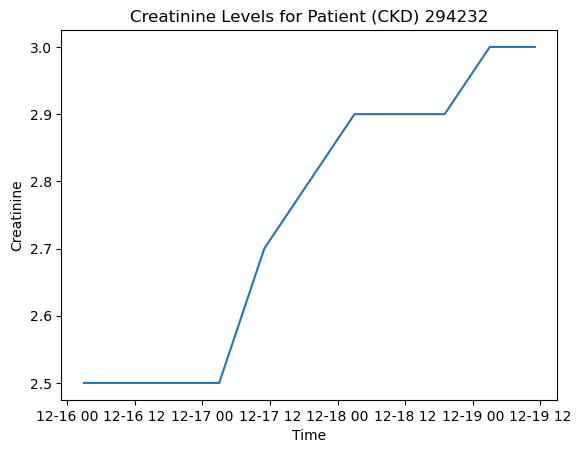

In [36]:
ckd_data = lab_ckd.merge(vital_ckd, on=['icustay_id', 'charttime'], how='outer')
creatinine_data = ckd_data[['icustay_id', 'charttime', 'creatinine']]
# Select data for a single patient
patient_data = creatinine_data[creatinine_data['icustay_id'] == 294232]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (CKD) {}'.format(294232))
plt.show()

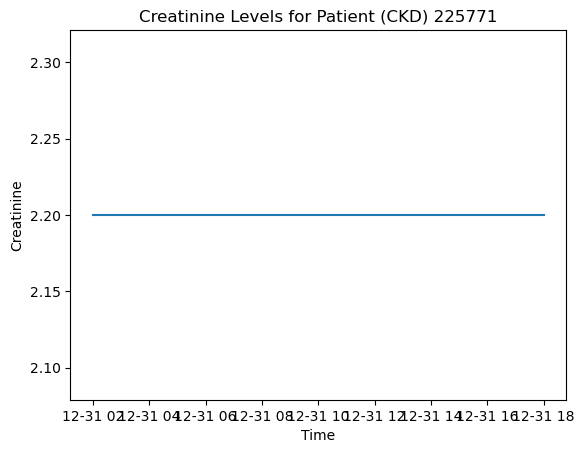

In [37]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 225771]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (CKD) {}'.format(225771))
plt.show()

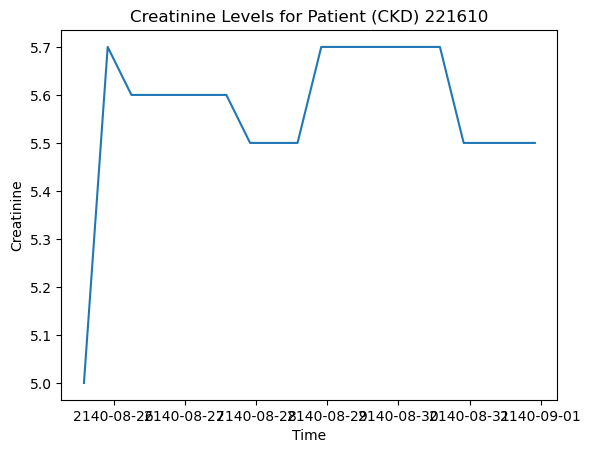

In [38]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 221610]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (CKD) {}'.format(221610))
plt.show()

In [40]:
nonckd_patients = icustay_details[icustay_details['ckd'] ==False]['icustay_id']
vital_nonckd = vital_resampled[vital_resampled['icustay_id'].isin(nonckd_patients)]
lab_nonckd = lab_resampled[lab_resampled['icustay_id'].isin(nonckd_patients)]

In [41]:
nonckd_patients.head(5)

0    228400
1    262702
2    202867
3    223805
4    226095
Name: icustay_id, dtype: int64

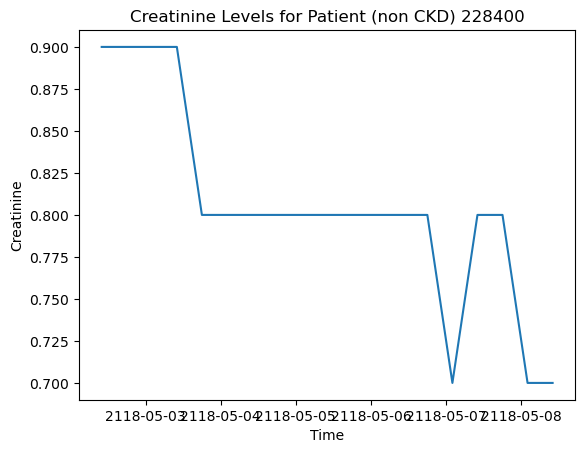

In [51]:
nonckd_data = lab_nonckd.merge(vital_ckd, on=['icustay_id', 'charttime'], how='outer')
creatinine_data = nonckd_data[['icustay_id', 'charttime', 'creatinine']]

patient_data = creatinine_data[creatinine_data['icustay_id'] ==228400]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (non CKD) {}'.format(228400))
plt.show()

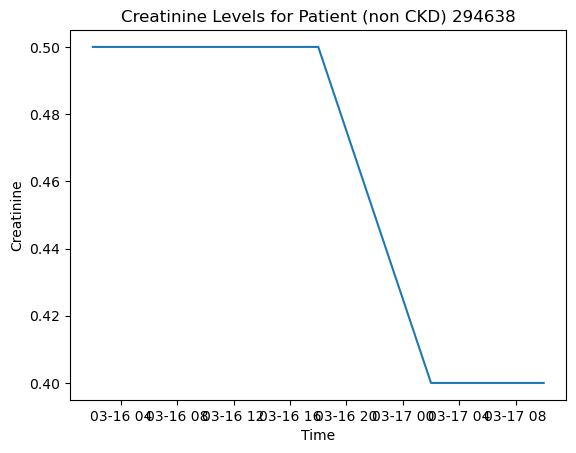

In [52]:
patient_data = creatinine_data[creatinine_data['icustay_id'] ==294638]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (non CKD) {}'.format(294638))
plt.show()

In [53]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 211552]
patient_data

,icustay_id,charttime,creatinine
98200,211552.0,2101-10-20 18:00:00,2.45
98201,211552.0,2101-10-21 02:00:00,2.50
98202,211552.0,2101-10-21 10:00:00,2.50
98203,211552.0,2101-10-21 18:00:00,2.50
98204,211552.0,2101-10-22 02:00:00,1.90
98205,211552.0,2101-10-22 10:00:00,1.90
98206,211552.0,2101-10-22 18:00:00,1.70
98207,211552.0,2101-10-23 02:00:00,1.60
98208,211552.0,2101-10-23 10:00:00,1.60
98209,211552.0,2101-10-23 18:00:00,1.60


In [54]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 243653]
patient_data

,icustay_id,charttime,creatinine
370853,243653.0,2138-07-17 20:00:00,-1.0


ICU stay duration/length for CKD patients

C:\Users\aakru\AppData\Local\Temp\ipykernel_16988\1004732647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ckd_icustay_detail['los'] = ckd_icustay_detail['outtime'] - ckd_icustay_detail['intime']
C:\Users\aakru\AppData\Local\Temp\ipykernel_16988\1004732647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ckd_icustay_detail['los_hours'] = ckd_icustay_detail['los'].astype('timedelta64[h]')


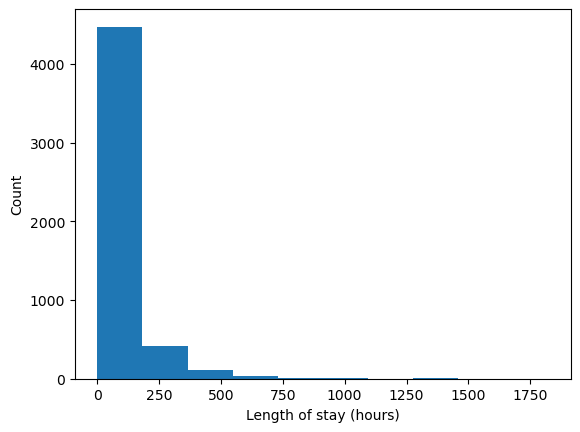

In [55]:
ckd_icustay_detail = icustay_details[icustay_details['icustay_id'].isin(ckd_patients)]
ckd_icustay_detail['los'] = ckd_icustay_detail['outtime'] - ckd_icustay_detail['intime']
ckd_icustay_detail['los_hours'] = ckd_icustay_detail['los'].astype('timedelta64[h]')
plt.hist(ckd_icustay_detail['los_hours'])
plt.xlabel('Length of stay (hours)')
plt.ylabel('Count')
plt.show()

<AxesSubplot:xlabel='ckd', ylabel='los_icu'>

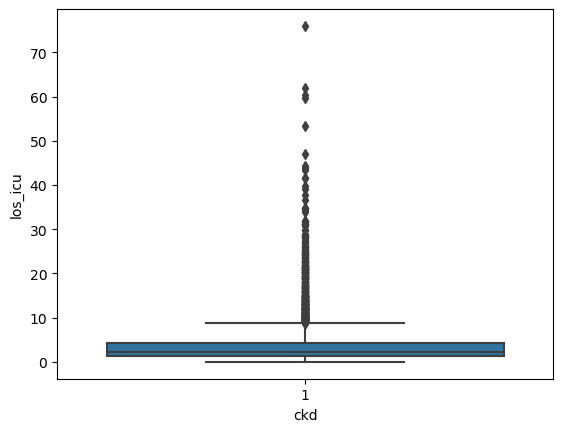

In [57]:
import seaborn as sns

# Filter CKD patients from icustay_detail dataframe
ckd_patients = icustay_details[icustay_details['ckd']==True]

# Create a boxplot
sns.boxplot(x='ckd', y='los_icu', data=ckd_patients)

In [58]:
lab_resampled.columns

Index(['icustay_id', 'charttime', 'subject_id', 'aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria', 'ckd'],
      dtype='object')

In [59]:
vital_resampled.columns

Index(['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity',
       'pedaledema', 'appetite_median', 'ckd'],
      dtype='object')